In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, dayofweek, month, radians, asin, sqrt, pow, dayofyear, log, exp, sin, cos, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt

In [7]:
spark = SparkSession.builder \
    .appName("Problem2 Structured API") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()


In [8]:
# Load data
try:
    train_data = spark.read.csv("train.csv", header=True, inferSchema=True)
except Exception as e:
    print(f"Error loading train data: {e}")
    spark.stop()
    exit(1)

train_data.show()

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1| -73.9821548461914| 40.76793670654297|-73.96463012695312|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.98041534423828|40.738563537597656|-73.99948120117188| 40.73115158081055|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:10:48|    

In [9]:
# Feature engineering function
def prepare_features(data):
    return data.withColumn("pickup_day_of_year", dayofyear("pickup_datetime")) \
        .withColumn("pickup_day_of_week", dayofweek("pickup_datetime")) \
        .withColumn("pickup_hour_of_day", hour("pickup_datetime")) \
        .withColumn("pickup_month", month("pickup_datetime")) \
        .withColumn("haversine",
                    6371 * 2 * asin(sqrt(pow(sin((radians("pickup_latitude") - radians("dropoff_latitude")) / 2), 2) +
                                         cos(radians("pickup_latitude")) * cos(radians("dropoff_latitude")) *
                                         pow(sin((radians("pickup_longitude") - radians("dropoff_longitude")) / 2),
                                             2))))


# Data cleaning and outlier removal using IQR
def remove_outliers(data, column, lower_quantile=0.25, upper_quantile=0.75, k=1.5):
    quantiles = data.approxQuantile(column, [lower_quantile, upper_quantile], 0.05)
    iqr = quantiles[1] - quantiles[0]
    lower_bound = quantiles[0] - k * iqr
    upper_bound = quantiles[1] + k * iqr
    return data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))


# Evaluate model
def evaluate_model(predictions, dataset_name):
    predictions = predictions.withColumn("predicted_duration", exp("prediction"))
    metrics = {}
    for metric in ["rmse", "mse", "mae", "r2"]:
        evaluator = RegressionEvaluator(labelCol="trip_duration", predictionCol="predicted_duration", metricName=metric)
        value = evaluator.evaluate(predictions)
        metrics[metric] = value
        print(f"\n{metric.upper()} on {dataset_name} = {value}")
    return metrics

In [10]:
# Features
train_data = prepare_features(train_data)
train_data.cache()

# Remove outliers
train_data = train_data.filter("haversine > 0").filter("passenger_count > 0").filter("trip_duration > 0")
train_data = remove_outliers(train_data, "trip_duration")
train_data = remove_outliers(train_data, "haversine")

# Add log-transformed target
train_data = train_data.withColumn("log_trip_duration", log("trip_duration"))

25/04/11 15:22:43 WARN CacheManager: Asked to cache already cached data.


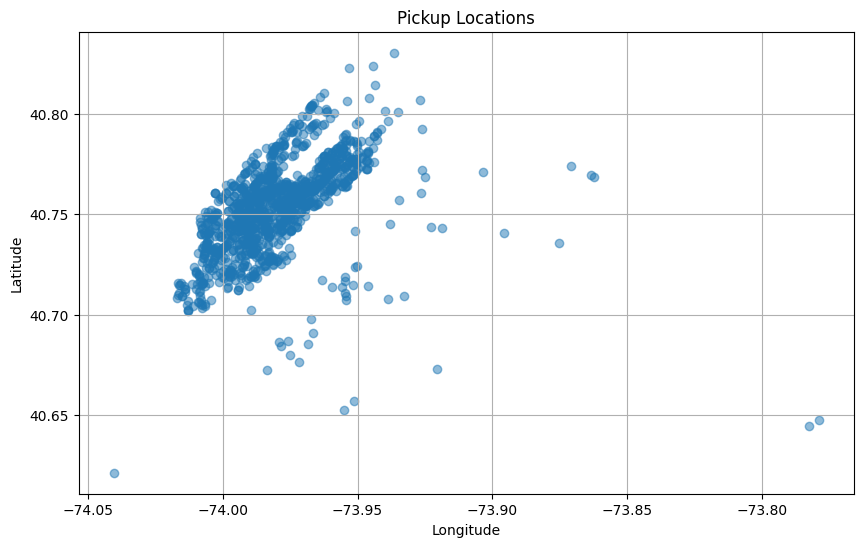

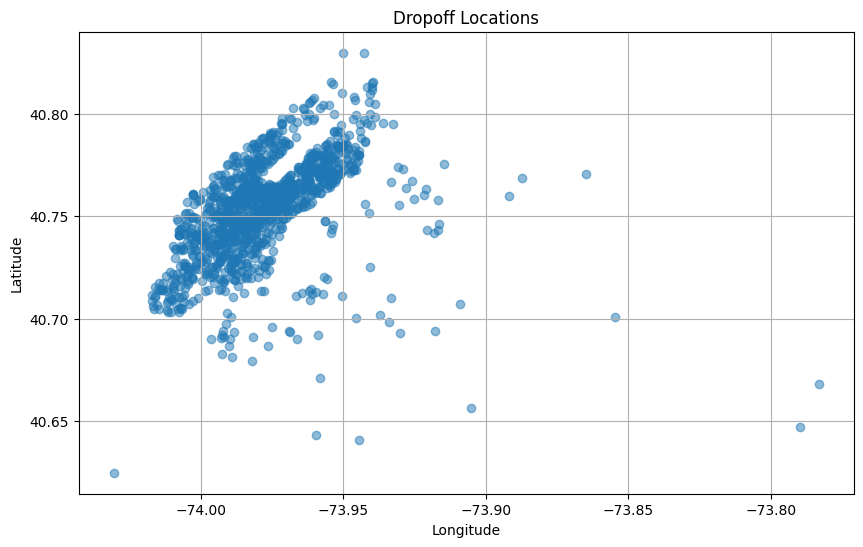

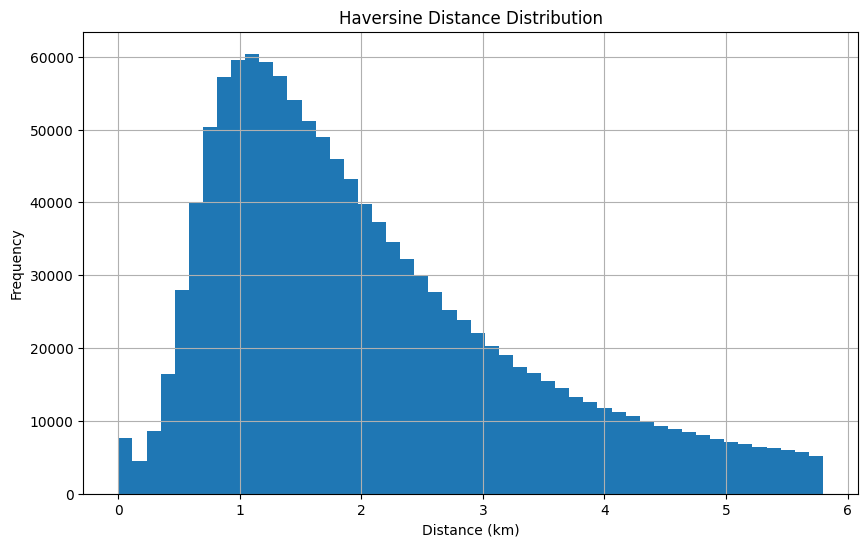

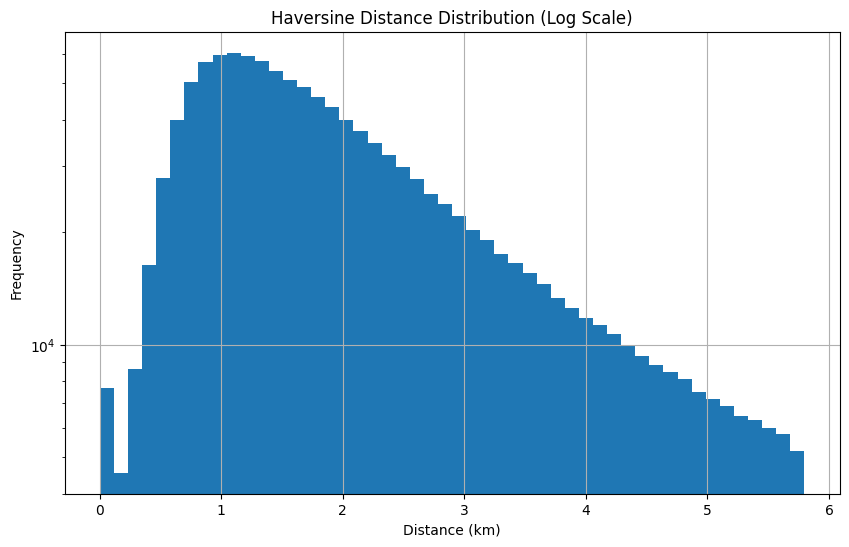

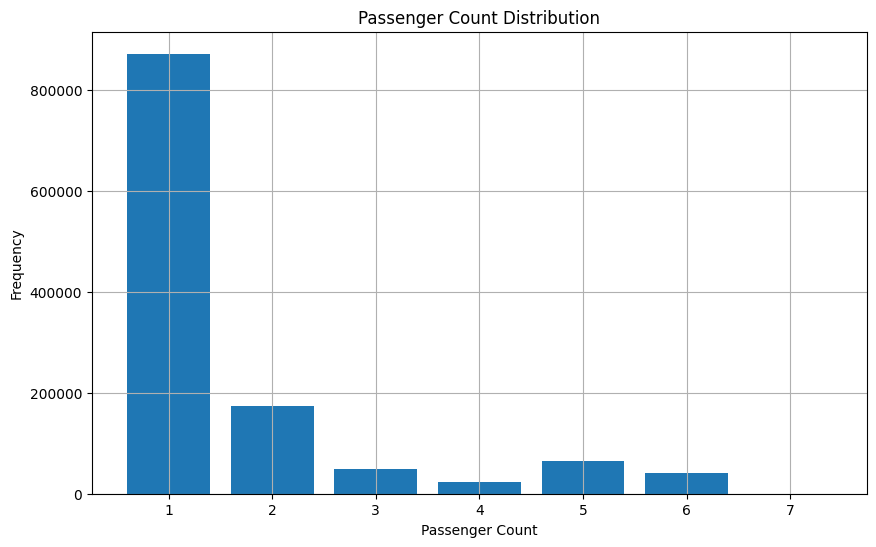

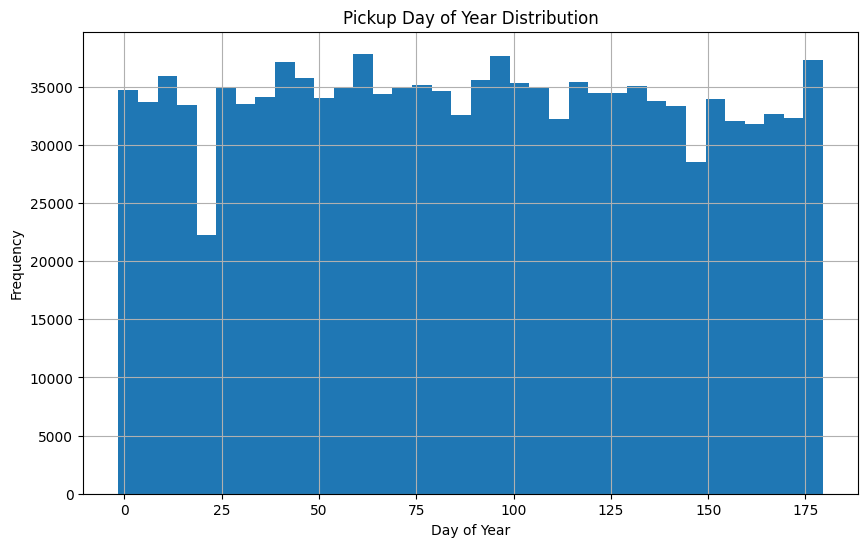

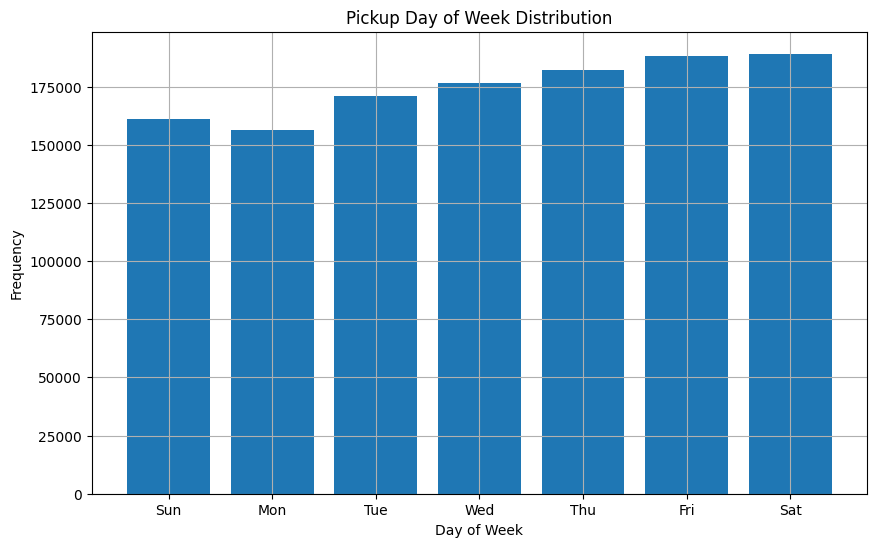

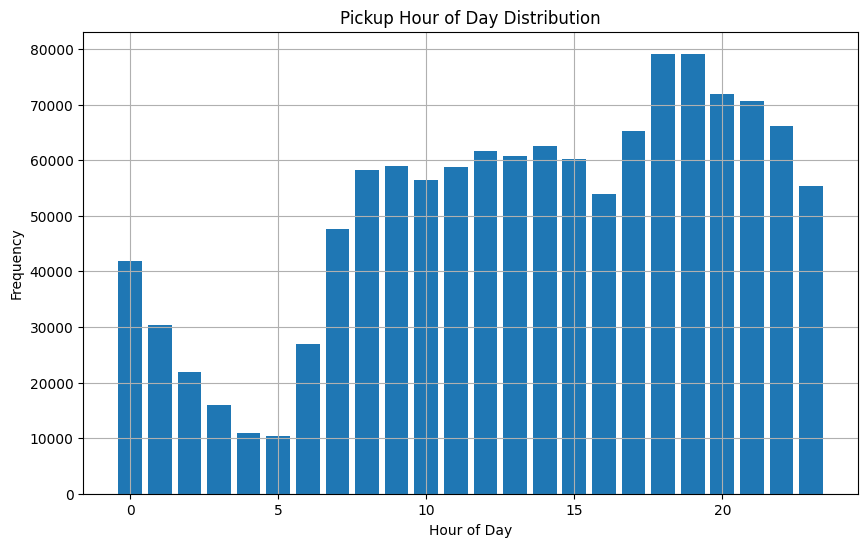

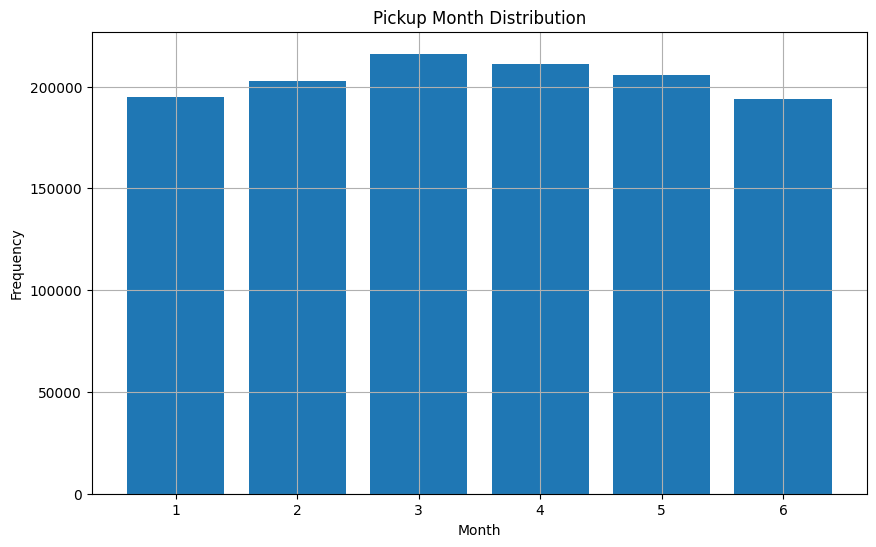

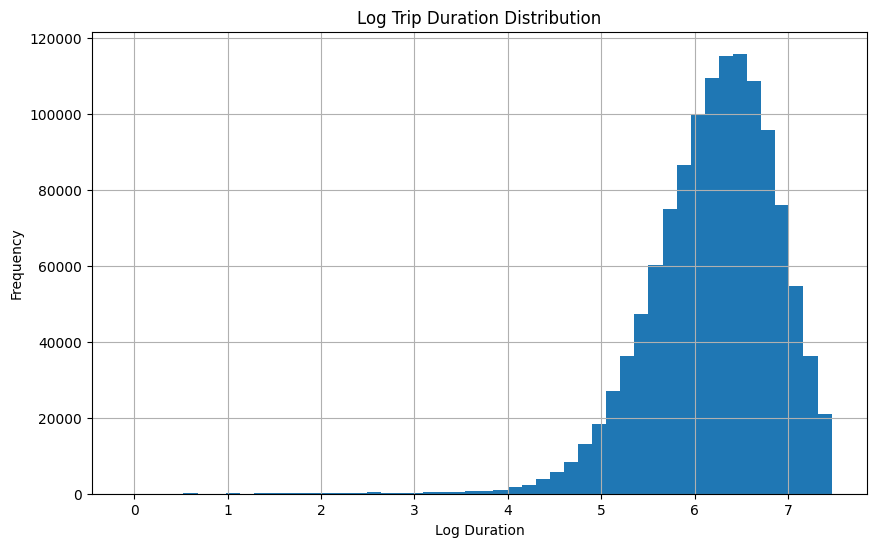

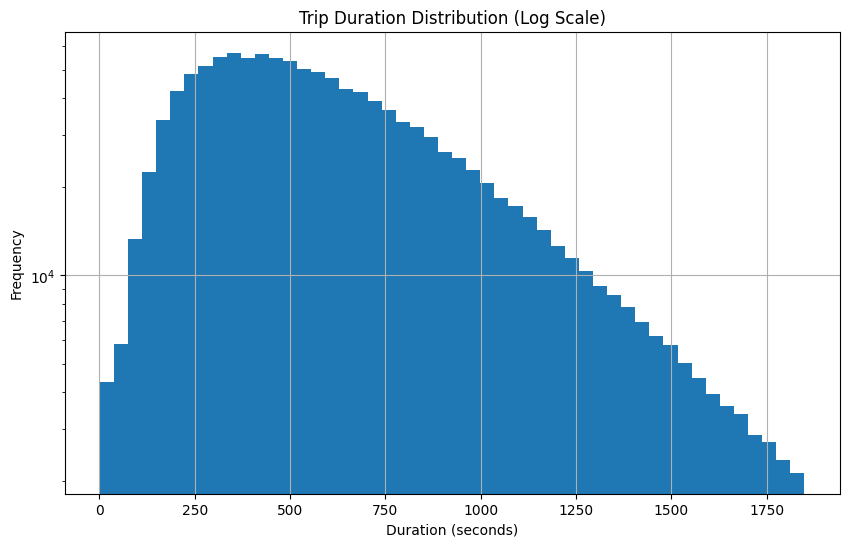

In [11]:
# Visualizations
try:
    # Scatter plot of pickup locations
    sample_pickup = train_data.select("pickup_longitude", "pickup_latitude").sample(fraction=0.001, seed=42).toPandas()
    plt.figure(figsize=(10, 6))
    plt.scatter(sample_pickup['pickup_longitude'], sample_pickup['pickup_latitude'], alpha=0.5)
    plt.title('Pickup Locations')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

    # Scatter plot of dropoff locations
    sample_dropoff = train_data.select("dropoff_longitude", "dropoff_latitude").sample(fraction=0.001,
                                                                                       seed=42).toPandas()
    plt.figure(figsize=(10, 6))
    plt.scatter(sample_dropoff['dropoff_longitude'], sample_dropoff['dropoff_latitude'], alpha=0.5)
    plt.title('Dropoff Locations')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

    # Histogram of haversine distance (initial)
    haversine_hist = train_data.select("haversine").rdd.flatMap(lambda x: x).histogram(50)
    plt.figure(figsize=(10, 6))
    plt.hist(haversine_hist[0][:-1], bins=50, weights=haversine_hist[1])
    plt.title('Haversine Distance Distribution')
    plt.xlabel('Distance (km)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Histogram of haversine distance (log-scaled)
    log_haversine_hist = train_data.select("haversine").rdd.flatMap(lambda x: x).histogram(50)
    plt.figure(figsize=(10, 6))
    plt.hist(log_haversine_hist[0][:-1], bins=50, weights=log_haversine_hist[1], log=True)
    plt.title('Haversine Distance Distribution (Log Scale)')
    plt.xlabel('Distance (km)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Bar chart of passenger_count
    passenger_counts = train_data.groupBy("passenger_count").count().orderBy("passenger_count").collect()
    passenger_labels = [row['passenger_count'] for row in passenger_counts]
    passenger_values = [row['count'] for row in passenger_counts]
    plt.figure(figsize=(10, 6))
    plt.bar(passenger_labels, passenger_values)
    plt.title('Passenger Count Distribution')
    plt.xlabel('Passenger Count')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Histogram of pickup_day_of_year
    day_of_year_hist = train_data.select("pickup_day_of_year").rdd.flatMap(lambda x: x).histogram(36)
    plt.figure(figsize=(10, 6))
    plt.bar(day_of_year_hist[0][:-1], day_of_year_hist[1], width=(day_of_year_hist[0][1] - day_of_year_hist[0][0]))
    plt.title('Pickup Day of Year Distribution')
    plt.xlabel('Day of Year')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Bar chart of pickup_day_of_week
    day_of_week_counts = train_data.groupBy("pickup_day_of_week").count().orderBy("pickup_day_of_week").collect()
    day_of_week_labels = [row['pickup_day_of_week'] for row in day_of_week_counts]
    day_of_week_values = [row['count'] for row in day_of_week_counts]
    day_names = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    plt.figure(figsize=(10, 6))
    plt.bar(day_of_week_labels, day_of_week_values)
    plt.xticks(ticks=range(1, 8), labels=day_names)
    plt.title('Pickup Day of Week Distribution')
    plt.xlabel('Day of Week')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Bar chart of pickup_hour_of_day
    hour_counts = train_data.groupBy("pickup_hour_of_day").count().orderBy("pickup_hour_of_day").collect()
    hour_labels = [row['pickup_hour_of_day'] for row in hour_counts]
    hour_values = [row['count'] for row in hour_counts]
    plt.figure(figsize=(10, 6))
    plt.bar(hour_labels, hour_values)
    plt.title('Pickup Hour of Day Distribution')
    plt.xlabel('Hour of Day')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Bar chart of pickup_month
    month_counts = train_data.groupBy("pickup_month").count().orderBy("pickup_month").collect()
    month_labels = [row['pickup_month'] for row in month_counts]
    month_values = [row['count'] for row in month_counts]
    plt.figure(figsize=(10, 6))
    plt.bar(month_labels, month_values)
    plt.title('Pickup Month Distribution')
    plt.xlabel('Month')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Histogram of log_trip_duration
    log_trip_duration_hist = train_data.select("log_trip_duration").rdd.flatMap(lambda x: x).histogram(50)
    plt.figure(figsize=(10, 6))
    plt.bar(log_trip_duration_hist[0][:-1], log_trip_duration_hist[1],
            width=(log_trip_duration_hist[0][1] - log_trip_duration_hist[0][0]))
    plt.title('Log Trip Duration Distribution')
    plt.xlabel('Log Duration')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Histogram of trip_duration (log-scaled)
    trip_duration_hist = train_data.select("trip_duration").rdd.flatMap(lambda x: x).histogram(50)
    plt.figure(figsize=(10, 6))
    plt.hist(trip_duration_hist[0][:-1], bins=50, weights=trip_duration_hist[1], log=True)
    plt.title('Trip Duration Distribution (Log Scale)')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error during visualization: {e}")

In [12]:
features = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude",
            "pickup_day_of_year", "pickup_day_of_week", "pickup_hour_of_day", "pickup_month",
            "haversine", "passenger_count"]

# VectorAssembler
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled_data = assembler.transform(train_data).select("id", "features", "log_trip_duration", "trip_duration")
assembled_data.cache()

DataFrame[id: string, features: vector, log_trip_duration: double, trip_duration: int]

In [13]:
# Define Decision Tree Regressor
decision_tree = DecisionTreeRegressor(featuresCol="features", labelCol="log_trip_duration", seed=42)

# Define parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(decision_tree.maxDepth, [5, 7, 10]) \
    .addGrid(decision_tree.minInstancesPerNode, [3, 5, 7, 10]) \
    .build()

# Define evaluator
evaluator = RegressionEvaluator(labelCol="log_trip_duration", predictionCol="prediction", metricName="rmse")

# Set up CrossValidator
crossval = CrossValidator(estimator=decision_tree,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5,
                          seed=42)

In [ ]:
# Train model
try:
    cv_model = crossval.fit(assembled_data)
    best_model = cv_model.bestModel
except Exception as e:
    print(f"Error during model training: {e}")
    spark.stop()
    exit(1)

# Split into training and validation sets for final evaluation
train, validation = assembled_data.randomSplit([0.8, 0.2], seed=42)

In [86]:
# Predictions and evaluation
train_predictions = best_model.transform(train)
print("\n=== Training Data Metrics ===")
train_metrics = evaluate_model(train_predictions, "training data")

validation_predictions = best_model.transform(validation)
print("\n=== Validation Data Metrics ===")
validation_metrics = evaluate_model(validation_predictions, "validation data")


=== Training Data Metrics ===



RMSE on training data = 239.98157361893158

MSE on training data = 57591.15567661868

MAE on training data = 171.56998965260658

R2 on training data = 0.5798282564158018

=== Validation Data Metrics ===

RMSE on validation data = 240.58480526167463

MSE on validation data = 57881.04852279791

MAE on validation data = 171.9566647811001

R2 on validation data = 0.5806032127256824


In [87]:
# Model diagnostics
print("\n=== Model Diagnostics ===")
print("Feature Importances:")
for i, importance in enumerate(best_model.featureImportances):
    print(f"{features[i]}: {importance}")

print("Decision Tree Depth:", best_model.depth)
print("Number of Nodes:", best_model.numNodes)
print("Number of Features:", best_model.numFeatures)
print("Best maxDepth:", best_model.getMaxDepth())
print("Best minInstancesPerNode:", best_model.getMinInstancesPerNode())

train_data.unpersist()
assembled_data.unpersist()
spark.stop()


=== Model Diagnostics ===
Feature Importances:
pickup_longitude: 0.004046910894402442
pickup_latitude: 0.0022995025434076237
dropoff_longitude: 0.010190264314407817
dropoff_latitude: 0.057695175233813935
pickup_day_of_year: 0.0004455068353380283
pickup_day_of_week: 0.026390409426790842
pickup_hour_of_day: 0.07548898412192576
pickup_month: 2.116073717798405e-06
haversine: 0.8223847575674554
passenger_count: 0.0010563729887403533
Decision Tree Depth: 10
Number of Nodes: 1935
Number of Features: 10
Best maxDepth: 10
Best minInstancesPerNode: 10
